Youwei Liu
8820 Final Project

This is a mechine learning project with pytorch that predict the next day's S&P 500 points, it will be trained using past 5 year data set, use the current 2024 trading days as test set to make the model more complete.

**Update:**
</br>output changed from 'Close/Last', 'Open', 'High', 'Low'->'Close/Last','5-day moving average'
</br>amount of data change from 50->20 to improve the fit
</br>find an better num_poches & lr combination to improve the fit:1000 & 0.012
</br>change of the normalization, now the function minimum will be at 0, maximum at 1
</br>after change of the normalization, the fit get worse for all the combination of num_poches & lr (reason unknown)
</br>Adding the objective measure of evaluation of the training modal 
</br>Improvement of the readability of the code and structure

**Data Collection:** Obtain historical S&P 500 data for the year 2023. You can use various sources like Yahoo Finance, Alpha Vantage, or Quandl to download this data. Ensure you have data for each trading day, including features like opening price, closing price, high, low, and volume.

**Data Preprocessing:** Preprocess the data by normalizing it, handling missing values, and selecting relevant features. You may also want to engineer additional features that could potentially improve prediction accuracy, such as moving averages, technical indicators, or sentiment analysis of news articles related to the stock market.

**Splitting Data:** Split the preprocessed data into training and testing sets. Since you want to use 2024 trading days as the test set, you'll use data from 2023 for training.n 2024.

In [1]:
import torch
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import pandas as pd
import torch

# Load the data
data_path = "C:/Users/Youwei Liu/LearningFromData/LectureNotes/notebooks/Project_SP500"
file_path = data_path + "/SP500_data_2023_ver.csv"
data = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')  # Adjusted date format

# Sort the data by date (optional but recommended for time series data)
data = data.sort_values(by='Date')

# Separate the data into input (date) and output (close, open, high, low) features
# Input features
input_features = data['Date']

# Output features
output_features = data[['Close/Last', 'Open', 'High', 'Low']]

# Convert input and output features to PyTorch tensors
input_tensor = torch.tensor(input_features.values.astype(float)).unsqueeze(1)  # unsqueeze to add a dimension for batch size
output_tensor = torch.tensor(output_features.values.astype(float))

split_date = int(0.9 * len(data))
split_50=50
split_train=20

# Compute the 5-day moving average for the 'Close/Last' prices
five_day_avg = output_features['Close/Last'].rolling(window=5).mean()

# Concatenate the 'Close/Last' prices and the 5-day moving average to form the train50_output tensor
close_last = output_features['Close/Last'].values.astype(float)
five_day_avg_tensor = five_day_avg.values.astype(float)
train50_output = []
for i in range(len(output_features)):
    if i < 5:
        # For the first 5 data points, use all available data points before the date
        train50_output.append([close_last[i], close_last[:i + 1].mean()])
    else:
        train50_output.append([close_last[i], five_day_avg_tensor[i]])

# Convert the list of lists to a tensor
train_output = torch.tensor(train50_output)

# Normalize the train50_output data
train50_input = input_tensor[:split_train]
#train50_input = input_tensor[range(50)]

# Compute the normalization factor
normalization_factor = torch.max(train_output[:split_train]) - torch.min(train_output[:split_train])
train50_output = (train_output[:split_train] - torch.min(train_output[:split_train])) / normalization_factor

test_inputs_days=input_tensor[split_train:split_50]
test_targets=(train_output[split_train:split_50] - torch.min(train_output[split_train:split_50])) / normalization_factor
# Print shapes to verify
print("Training Input Shape:", train50_input.shape)
print("Training Output Shape:", train50_output.shape)


Training Input Shape: torch.Size([20, 1])
Training Output Shape: torch.Size([20, 2])


**Model Building:** Design and implement a neural network model using PyTorch. You can start with a simple architecture like a feedforward neural network or a recurrent neural network (RNN). Experiment with different architectures, activation functions, and optimization algorithms to find the best model for your 

That's very interesting,seems like the order of activation function affect a lot in the final fit, since periodical function gives an output value range from -1 to 1. task.

In [3]:
class PeriodicActivation(nn.Module):
    def __init__(self):
        super(PeriodicActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)  # You can replace 'torch.sin' with 'torch.cos' for a cosine function

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=50)
        self.fc4 = nn.Linear(in_features=50, out_features=2)
        self.periodic_activation = PeriodicActivation()  # Periodic activation function
        self.tanh = nn.Tanh()
        self.elu=nn.ELU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.periodic_activation(x)# Apply periodic activation function
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.elu(x)
        x = self.fc4(x)
        return x

# Example usage:
model = NeuralNetwork()
input_tensor = torch.randn(3, 1)  # Example input tensor (batch size 5, input size 1)
output_tensor = model(input_tensor)


# Print the network structure
#print(net)

</br>test function to show if the model fits an relative complex function of xsinx+kx
</br>seems for this function it works until 50*pi range, on high range it failed to detact the macroscopic increasing nature of the function
</br>or in the other word the algorithm will always try to best fit the value close to 0 first, to get a large scale order, it need way more points

In [4]:
# # Generate some training data
# x_train = np.linspace(0, 50*np.pi, 1000).reshape(-1, 1).astype(np.float32)
# y_train = (x_train* np.sin(x_train) +5*x_train).astype(np.float32)

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Convert numpy arrays to PyTorch tensors
# x_train_tensor = torch.from_numpy(x_train)
# y_train_tensor = torch.from_numpy(y_train)

# # Training the model
# num_epochs = 1000
# for epoch in range(num_epochs):
#     # Forward pass
#     outputs = model(x_train_tensor)
#     loss = criterion(outputs, y_train_tensor)

#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# # Generate some test data
# x_test = np.linspace(0, 51*np.pi, 100).reshape(-1, 1).astype(np.float32)
# x_test_tensor = torch.from_numpy(x_test)

# # Predict using the trained model
# with torch.no_grad():
#     y_pred_tensor = model(x_test_tensor).numpy()

# # Plot the results
# plt.figure(figsize=(8, 6))
# plt.plot(x_test, x_test*np.sin(x_test)+5*x_test, label='True Function')
# plt.plot(x_test, y_pred_tensor, label='Predicted Function', linestyle='--')
# plt.xlabel('x')
# plt.ylabel('f(x)')
# plt.title('Fitting x*sin(x) with Neural Network (PyTorch)')
# plt.legend()
# plt.grid(True)
# plt.show()

**Training:** Train your model using the training dataset. Define a loss function (e.g., Mean Squared Error) and choose an optimizer (e.g., Adam). Train the model for multiple epochs, monitoring the loss on the validation set to avoid overfitting.

In [5]:
#due to the failing of long range code, this is short range code for only 50 days:
#still seems not working, maybe because the the oscillation is too sharp between day to day, increase the number of epochs from 1000 to 10000 doesn't help in this case
#it might be a go idea to further process the data:(like to find the moving average for 5 days and then apply machine learning again)

# interestingly, adding more num_pochs make the graph more "flat"(linear slope ->0) maybe there are some overfitting happening? 
# the best combination so far found for this model is lr=0.012, num_epochs = 1000


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Create a DataLoader for the training set
train50_dataset = TensorDataset(train50_input, train50_output)
train_loader = DataLoader(train50_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Convert inputs and targets to the same data type as the model's parameters
        inputs = inputs.float()
        targets = targets.float()
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train50_dataset)
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

Training finished!


**Evaluation:** Evaluate the trained model on the test set (2024 trading days). Calculate metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) to assess the model's performance.


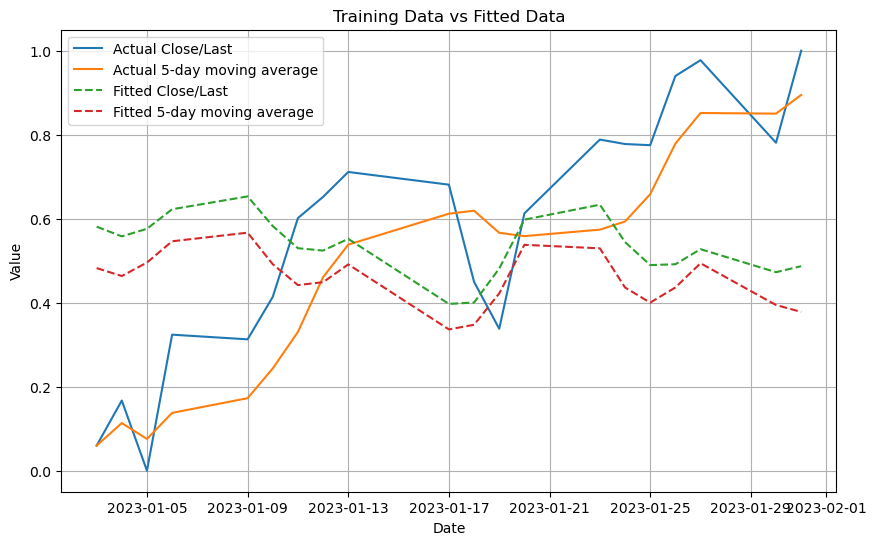

In [6]:
#seems the moving average do not improve the training too much, 

# Convert tensors to numpy arrays
train50_input_array = train50_input.numpy()
train50_output_array = train50_output.numpy()

# Create a DataFrame with input features and target values
train50_data_processed = pd.DataFrame({
    'Date': train50_input_array[:, 0],  # Assuming the first column contains dates
    'Close/Last': train50_output_array[:, 0],  # Assuming the first column contains Close/Last values
    '5-day moving average': train50_output_array[:, 1],  # Assuming the second column contains Open values
})

# Assuming 'Date' column is in datetime format, if not, convert it
if not pd.api.types.is_datetime64_any_dtype(train50_data_processed['Date']):
    train50_data_processed['Date'] = pd.to_datetime(train50_data_processed['Date'])

# Sort the DataFrame by date
train50_data = train50_data_processed.sort_values(by='Date').reset_index(drop=True)

# Convert datetime values to the number of days since a reference date
reference50_date = train50_data['Date'].min()  # Use the minimum date as the reference
inputs50_days = (train50_data['Date'] - reference50_date).dt.days.values.reshape(-1, 1)

# Pass input features through the trained model to obtain predicted target values
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    inputs50_tensor = torch.tensor(inputs50_days, dtype=torch.float32)  # Convert input features to tensor
    predicted50_targets = model(inputs50_tensor)  # Predicted target values from the model

# Plot the training data and fitted data
plt.figure(figsize=(10, 6))

# Plot actual target values (training data)
for i, column in enumerate(train50_data.columns[1:]):  # Exclude the 'Date' column
    plt.plot(train50_data['Date'], train50_data[column], label=f'Actual {column}')

# Plot predicted target values (fitted data)
for i, column in enumerate(train50_data.columns[1:]):  # Exclude the 'Date' column
    plt.plot(train50_data['Date'], predicted50_targets[:, i], linestyle='--', label=f'Fitted {column}')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training Data vs Fitted Data')
plt.legend()
plt.grid(True)
plt.show()

**Analysing the dataset**

In [7]:
# Convert the tensors to numpy arrays for ease of calculation
actual_values = train50_data[['Close/Last', '5-day moving average']].values
predicted_values = predicted50_targets.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = mean_squared_error(actual_values, predicted_values, squared=False)
r2 = r2_score(actual_values, predicted_values)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.09805777625624765
Mean Absolute Error (MAE): 0.26995180382816647
Root Mean Squared Error (RMSE): 0.3130381299350994
R-squared (R2): -0.27647670226863175


**Prediction:** Once you're satisfied with the model's performance, you can use it to predict the next day's S&P 500 points for the current trading days in 2024.

Actually this prediction is pretty good, it do replicate some feature for short term flucations but fail to show the long term trend

C:\Users\Youwei Liu\AppData\Local\Temp\ipykernel_18976\4005463759.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs_tensor = torch.tensor(test_inputs_days, dtype=torch.float32)  # Convert test input features to tensor


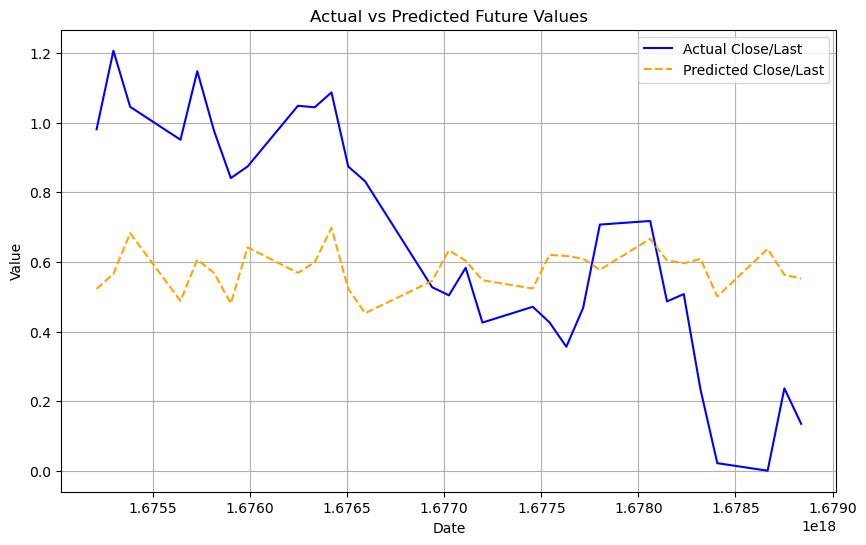

Mean Squared Error (MSE): 0.12231993251283088
R-squared (R2) Score: -0.3313323192931411


In [13]:
# Step 1: Predict Future Values
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    test_inputs_tensor = torch.tensor(test_inputs_days, dtype=torch.float32)  # Convert test input features to tensor
    predicted_future_targets = model(test_inputs_tensor)  # Predict future target values from the model


# Step 2: Compute Assessment Metric
# For example, let's use Mean Squared Error (MSE) and R-squared (R2) score
mse = mean_squared_error(test_targets, predicted_future_targets)
r2 = r2_score(test_targets, predicted_future_targets)

test_inputs_array = test_inputs_tensor.numpy()

# Step 3: Compare Predictions with Actual Values and Plot
plt.figure(figsize=(10, 6))

# Plot actual test set values
plt.plot(test_inputs_array[:, 0], test_targets[:, 0], label='Actual Close/Last', color='blue')

# Plot predicted future values
plt.plot(test_inputs_array[:, 0], predicted_future_targets[:, 0], label='Predicted Close/Last', linestyle='--', color='orange')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Future Values')
plt.legend()
plt.grid(True)
plt.show()

# Display or output the computed assessment values
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

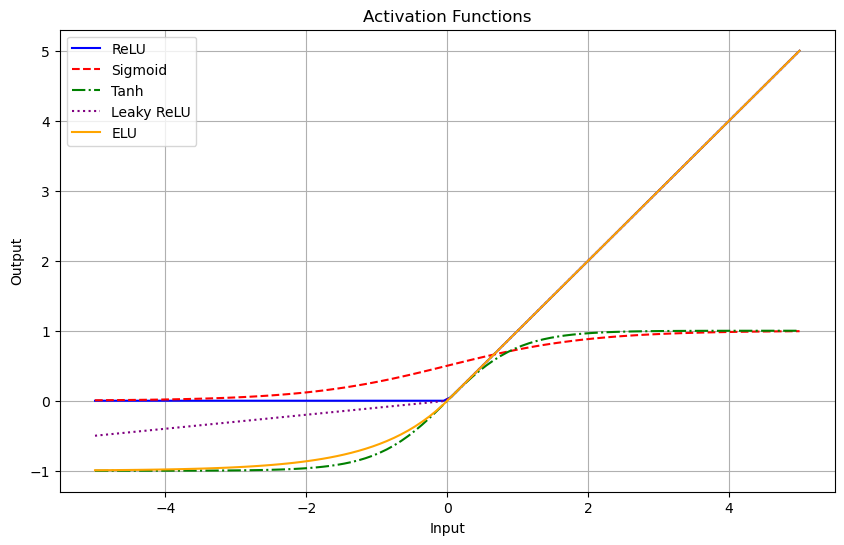

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Define input values
x = np.linspace(-5, 5, 100)
x_tensor = torch.tensor(x, dtype=torch.float32)

# Define activation functions
relu_y = F.relu(x_tensor).numpy()
sigmoid_y = torch.sigmoid(x_tensor).numpy()
tanh_y = torch.tanh(x_tensor).numpy()
leaky_relu_y = F.leaky_relu(x_tensor, negative_slope=0.1).numpy()
elu_y = F.elu(x_tensor).numpy()

# Plot the activation functions
plt.figure(figsize=(10, 6))

plt.plot(x, relu_y, label='ReLU', linestyle='-', color='blue')
plt.plot(x, sigmoid_y, label='Sigmoid', linestyle='--', color='red')
plt.plot(x, tanh_y, label='Tanh', linestyle='-.', color='green')
plt.plot(x, leaky_relu_y, label='Leaky ReLU', linestyle=':', color='purple')
plt.plot(x, elu_y, label='ELU', linestyle='-', color='orange')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Activation Functions')
plt.legend()
plt.grid(True)
plt.show()